# Soil Organic Carbon
<br>

### Global Soil Organic Carbon Map v1.5 (GSOC)
- https://data.apps.fao.org/catalog/dataset/7730e747-eb73-49c9-bfe6-84ebae718743

In [1]:
# File and Data Manipulation
import os                       # interacting with the operating system
import glob                     # retrieving files/pathnames matching a specified pattern
from collections import Counter # counting hashable objects
import shutil                   # high-level file operations
import pickle                   # serializing and de-serializing Python object structures

# File and Temporary Data Management
import tempfile  # for creating temporary files and directories

# Data Analysis
import numpy as np              # numerical operations
import pandas as pd             # data manipulation and analysis

# Geospatial Data Handling
import geopandas as gpd         # working with geospatial data

# Data Visualization
import matplotlib.pyplot as plt       # creating static, interactive, and animated visualizations
plt.style.use("default")              # Set the default style matplotlib plots
import matplotlib.colors as mcolors   # colors for legend
import matplotlib.patches as mpatches # drawing patches (shapes) for legend
from matplotlib.ticker import MaxNLocator     # control the maximum number of ticks on plots
from matplotlib.ticker import MultipleLocator # control tick intervals on plots
import matplotlib.ticker as mticker           # advanced tick formatting and placement
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset for colorbar

# Raster Operations
import rasterio                       # core library
from rasterio.plot import show        # for displaying raster images

# Data Transformation and Resampling
from rasterio.enums import Resampling # different resampling algorithms
from rasterio.warp import calculate_default_transform # transformation calculation for reprojecting
from rasterio.warp import reproject   # for reprojecting raster data

# Geospatial Analysis and Masking
from rasterio.mask import mask              # masking raster data based on shapes
from rasterio.features import geometry_mask # creating masks from geometric shapes

# Advanced Raster Operations
from rasterio.merge import merge          # merging multiple raster datasets
from rasterio.plot import plotting_extent # plotting extent for matplotlib alignment
from rasterio.crs import CRS              # handling Coordinate Reference Systems

# Memory Handling and I/O Operations
from rasterio.io import MemoryFile        # in-memory raster data operations

# Suppress Warnings
import warnings                   # handling warnings
warnings.filterwarnings("ignore") # Suppress all warnings (use with caution!)

In [2]:
# Define Working Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data')

# Yenisey Watershed (Shapefile)
AGRO_Watershed = gpd.read_file('ArcticGRO_Yenisei_watershed')
# Lakes (Shapefile)
gpd_lakes = gpd.read_file('GeoPandas_Yenisei_lakes')

#### Check out the Raster Data

In [3]:
# Global Soil Organic Carbon
file_path = "GSOCmap150.tif"

with rasterio.open(file_path) as src:
    meta = src.meta # Metadata
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4e+38,
 'width': 43200,
 'height': 18544,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0083333333, 0.0, -180.0,
        0.0, -0.008333333299989214, 83.616081247)}

### Function to Clip a Raster to a Shapefile

In [4]:
#Clip Raster to a Shapefile
def clip_raster_by_geometry(raster_path, geometry, output_path):
    """
    Clip a raster based on given geometry.

    Parameters:
    - raster_path (str): Path to the input raster file.
    - geometry (geopandas.GeoSeries or GeoDataFrame): The geometry to clip with.
    - output_path (str): Path to the output clipped raster file.
    """
    
    # Check if the output file already exists
    if os.path.exists(output_path):
        print(f"The file {output_path} already exists!")
        return
    
    with rasterio.open(raster_path) as src:
        clipped, transform = mask(src, geometry, crop=True)
        clipped_meta = src.meta.copy()  # Get metadata of the original raster
        clipped_meta.update({
            "driver": "GTiff", 
            "height": clipped.shape[1], 
            "width": clipped.shape[2], 
            "transform": transform
        })

        with rasterio.open(output_path, "w", **clipped_meta) as dest:
            dest.write(clipped)

In [5]:
# Clip Raster to the Yenisey River Basin Watershed
file_path_raster = 'GSOCmap150.tif'
output_file = "GSOC_Yenisey.tif"
geometry = AGRO_Watershed.geometry
clip_raster_by_geometry(file_path_raster, geometry, output_file)

The file GSOC_Yenisey.tif already exists!


In [6]:
output_file = "GSOC_Yenisey.tif"

with rasterio.open(output_file) as src:
    meta = src.meta

meta

# 'nodata': -3.4e+38

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4e+38,
 'width': 3708,
 'height': 3032,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0083333333, 0.0, 83.9833322774,
        0.0, -0.008333333299989214, 71.63274796161551)}

#### Look at the distribution of the data
> SOC, [tonnes/hectare]

Number of Unique Values: 563798

Mean: 83.9
Range: (0.0 - 405.0)



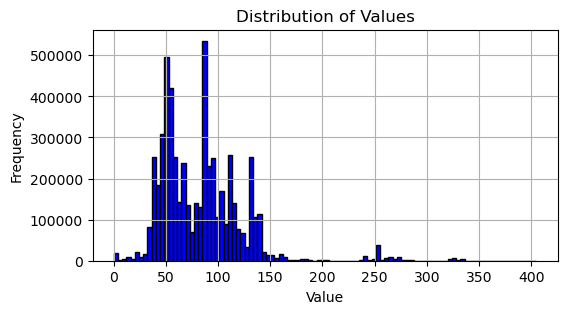

In [7]:
with rasterio.open(output_file) as src:
    # Read the raster data into an np.array
    data = src.read(1, masked=True) # Call Band 1 and Mask the nodata values (-3.4e+38)
    unique_values = np.unique(data) # Get unique values from the data array
    print("Number of Unique Values:", len(unique_values))

    # Calculate statistics on the data array
    mean_value = np.nanmean(data)
    min_value = np.nanmin(data)
    max_value = np.nanmax(data)
    print()
    print(f'Mean: {mean_value:.1f}')
    print(f'Range: ({min_value} - {max_value})')
    print()

# Plot
plt.figure(figsize=(6, 3))
plt.hist(data.ravel(), bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)

#plt.savefig("J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data\Chomiak_Yenisey_Final_Maps\GSOC_Yenisey_histogram.png", dpi=600, bbox_inches='tight')

#### Plot the Data

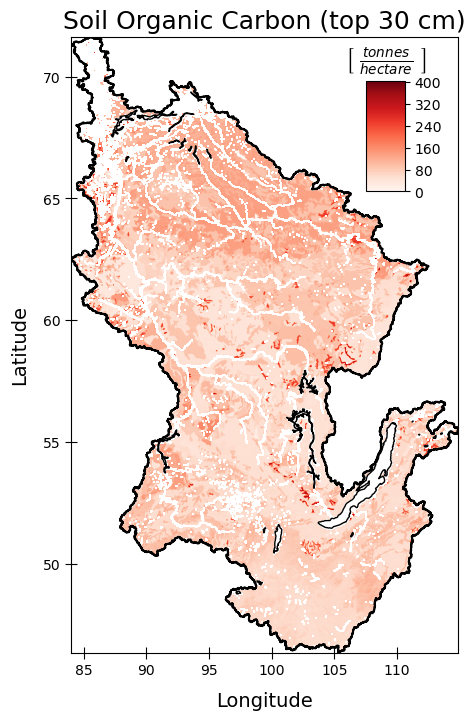

In [8]:
with rasterio.open(output_file) as src:
    data = src.read(1, masked=True)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Display the raster using the raster_extent 
img = ax.imshow(data, cmap='Reds', extent=raster_extent, vmin=0) 

# Set title and labels
ax.set_title('Soil Organic Carbon (top 30 cm)', fontsize=18)
ax.set_xlabel('Longitude', color='black', fontsize=14, labelpad=10)
ax.set_ylabel('Latitude', color='black', fontsize=14, labelpad=10)
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)
gpd_lakes.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=6)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)

#cbar = plt.colorbar(img, ax=ax)
#cbar.set_label('tonnes/hectare', size=20)

# Create custom colorbar
cb_ax = inset_axes(ax, width="10%", height="18%", loc='upper right', 
                   bbox_to_anchor=(-0.120, -0.060, 1, 1), bbox_transform=ax.transAxes)
cb = plt.colorbar(img, cax=cb_ax)
cb.set_label(r'$\left[\ \frac{tonnes}{hectare}\ \right]$', fontsize=10, labelpad=15)
#cb.set_label(r'$\left[\frac{tonnes}{hectare}\right]$', fontsize=20, labelpad=15)
cb.ax.tick_params(labelsize=10)
# Adjust label position and orientation
cb.ax.yaxis.set_label_coords(0.51, 1.18)
cb.ax.set_ylabel(cb.ax.get_ylabel(), rotation=0, fontsize=14, ha='center', va='center')
# Set the locator for the ticks
cb.locator = MaxNLocator(nbins=6)  # 'nbins' determines the maximum number of ticks
cb.update_ticks()

#### Use percentiles to make the map more explanatory

The 2nd and 98th percentiles will be looked at. The 2nd percentile means that 2% of the data points are below this value, and 98% are above it. The 98th percentile indicates that 98% of the data points are below this value, and 2% are above it. 

Based on a visual assessment, the 98.5th percentile will be used as the vmax for the colorbar. 

In [9]:
with rasterio.open(output_file) as src:
    data = src.read(1, masked=True)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Compute the 2nd and 98th percentiles
    p2 = np.percentile(data.compressed(), 2)
    p98 = np.percentile(data.compressed(), 98.5)
    print(p2)
    print(p98)
    
# use .compressed() because np.percentile does not ignore the mask function

33.0
252.0


Anything pixel with a value above 151.6 will have the darkest shade of red.

Text(340, 149, ' <')

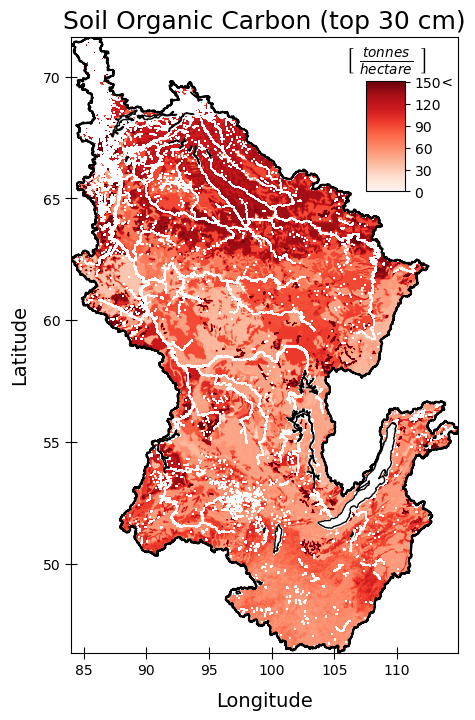

In [10]:
with rasterio.open(output_file) as src:
    data = src.read(1, masked=True)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Compute the 2nd and 98th percentiles
   # p2 = np.percentile(valid_data_values, 2)
    p98 = np.percentile(data, 98.5)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Display the raster using the raster_extent and adjusted color limits
img = ax.imshow(data, cmap='Reds', extent=raster_extent, vmin=0, vmax=p98) #vmin=p2, 

# Set title and labels
ax.set_title('Soil Organic Carbon (top 30 cm)', fontsize=18)
ax.set_xlabel('Longitude', color='black', fontsize=14, labelpad=10)
ax.set_ylabel('Latitude', color='black', fontsize=14, labelpad=10)
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)
gpd_lakes.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=6)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)

#cbar = plt.colorbar(img, ax=ax)
#cbar.set_label('tonnes/hectare', size=20)

# Create custom colorbar
cb_ax = inset_axes(ax, width="10%", height="18%", loc='upper right', 
                   bbox_to_anchor=(-0.120, -0.060, 1, 1), bbox_transform=ax.transAxes)
cb = plt.colorbar(img, cax=cb_ax)
cb.set_label(r'$\left[\ \frac{tonnes}{hectare}\ \right]$', fontsize=10, labelpad=15)
#cb.set_label(r'$\left[\frac{tonnes}{hectare}\right]$', fontsize=20, labelpad=15)
cb.ax.tick_params(labelsize=10)
# Adjust label position and orientation
cb.ax.yaxis.set_label_coords(0.51, 1.18)
cb.ax.set_ylabel(cb.ax.get_ylabel(), rotation=0, fontsize=14, ha='center', va='center')
# Set the locator for the ticks
cb.locator = MaxNLocator(nbins=6)  # 'nbins' determines the maximum number of ticks
cb.update_ticks()
#cb.ax.axhline(y=p98, color='red', linestyle='--')
cb.ax.text(340, 149, ' <', va='center', ha='right', color='black', fontsize=10)


#fig.savefig("J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data\Chomiak_Yenisey_Final_Maps\GSOC_Yenisey.png", dpi=600, bbox_inches='tight')

# Part II:
### Find amount of SOC in Tundra and Taiga Biomes

### Import Ecoregions Shapefile

In [11]:
# EcoRegions(Shapefile)
file_path = 'Yenisey_RESOLVE_Ecoregions'
eco = gpd.read_file(file_path)
eco.head(1)

,BIOME_NUM,ECO_BIOME_,BIOME_NAME,NNH,REALM,SHAPE_AREA,OBJECTID,COLOR_NNH,COLOR_BIO,COLOR,ECO_NAME,SHAPE_LENG,ECO_ID,LICENSE,NNH_NAME,geometry
0,8.0,PA08,"Temperate Grasslands, Savannas & Shrublands",3,Palearctic,103.136132,450.0,#F9A91B,#FEFF73,#F6FC38,Mongolian-Manchurian grassland,134.47724,734,CC-BY 4.0,Nature Could Recover,"POLYGON ((101.95419 47.74875, 101.96336 47.774..."


In [12]:
eco.head(1)

,BIOME_NUM,ECO_BIOME_,BIOME_NAME,NNH,REALM,SHAPE_AREA,OBJECTID,COLOR_NNH,COLOR_BIO,COLOR,ECO_NAME,SHAPE_LENG,ECO_ID,LICENSE,NNH_NAME,geometry
0,8.0,PA08,"Temperate Grasslands, Savannas & Shrublands",3,Palearctic,103.136132,450.0,#F9A91B,#FEFF73,#F6FC38,Mongolian-Manchurian grassland,134.47724,734,CC-BY 4.0,Nature Could Recover,"POLYGON ((101.95419 47.74875, 101.96336 47.774..."


<AxesSubplot:>

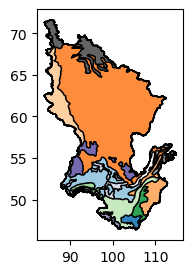

In [13]:
# Quick Plot
fig, ax = plt.subplots(figsize=(3, 3))
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=2)
eco.plot(ax=ax, color=eco['COLOR_BIO'], cmap='tab20c', edgecolor='black', lw=1)

#### Isolate Tundra and Taiga

In [14]:
# Create individual GeoDataFrames for EcoRegions of Interest
boreal_forest = eco[eco['BIOME_NAME'] == 'Boreal Forests/Taiga']
tundra = eco[eco['BIOME_NAME'] == 'Tundra']

epsg:4326


<AxesSubplot:>

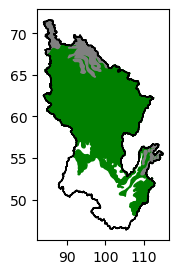

In [15]:
# Quick Plot
print(boreal_forest.crs)
fig, ax = plt.subplots(figsize=(3, 3))
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=2)
boreal_forest.plot(ax=ax, color='green', edgecolor='green', lw=1)
tundra.plot(ax=ax, color='grey', edgecolor='grey', lw=1)

#### Clip SOC (Raster) to Taiga (Shapefile)

In [16]:
%%time
# Clip Raster to the Biome of Interest
file_path_raster = 'GSOC_Yenisey.tif'
GSOC_Yenisey_Taiga_4326 = "GSOC_Yenisey_Taiga_4326.tif"
boreal_forest_geometry = boreal_forest.geometry
clip_raster_by_geometry(file_path_raster, boreal_forest_geometry, GSOC_Yenisey_Taiga_4326)

The file GSOC_Yenisey_Taiga_4326.tif already exists!
Wall time: 997 µs


#### Clip SOC (Raster) to Tundra (Shapefile)

In [17]:
%%time
# Clip Raster to the Biome of Interest
file_path_raster = 'GSOC_Yenisey.tif' # Raster file
GSOC_Yenisey_Tundra_4326 = "GSOC_Yenisey_Tundra_4326.tif"
tundra_geometry = tundra.geometry 
clip_raster_by_geometry(file_path_raster, tundra_geometry, GSOC_Yenisey_Tundra_4326)

The file GSOC_Yenisey_Tundra_4326.tif already exists!
Wall time: 1.03 ms


#### Plot Results

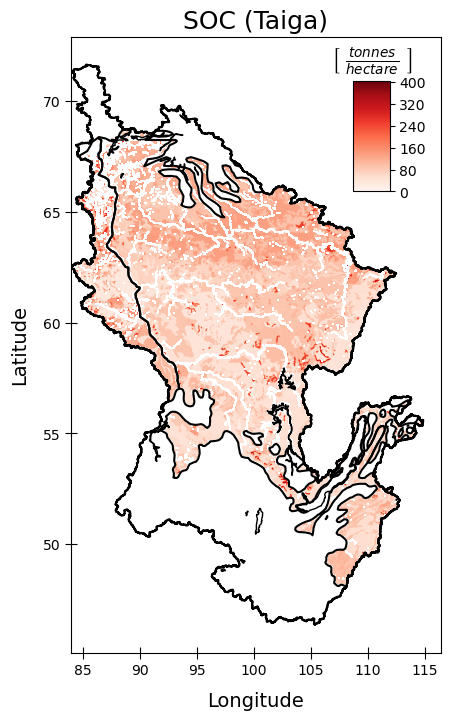

In [18]:
with rasterio.open(GSOC_Yenisey_Taiga_4326) as src:
    data = src.read(1, masked=True)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    # Compute the 2nd and 98th percentiles
    p98 = np.percentile(data, 98.5)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Display the raster using the raster_extent and adjusted color limits
img = ax.imshow(data, cmap='Reds', extent=raster_extent)

# Set title and labels
ax.set_title('SOC (Taiga)', fontsize=18)
ax.set_xlabel('Longitude', color='black', fontsize=14, labelpad=10)
ax.set_ylabel('Latitude', color='black', fontsize=14, labelpad=10)
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)
boreal_forest.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)
gpd_lakes.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=6)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)

# Create custom colorbar
cb_ax = inset_axes(ax, width="10%", height="18%", loc='upper right', 
                   bbox_to_anchor=(-0.120, -0.060, 1, 1), bbox_transform=ax.transAxes)
cb = plt.colorbar(img, cax=cb_ax)
cb.set_label(r'$\left[\ \frac{tonnes}{hectare}\ \right]$', fontsize=10, labelpad=15)
#cb.set_label(r'$\left[\frac{tonnes}{hectare}\right]$', fontsize=20, labelpad=15)
cb.ax.tick_params(labelsize=10)
# Adjust label position and orientation
cb.ax.yaxis.set_label_coords(0.51, 1.18)
cb.ax.set_ylabel(cb.ax.get_ylabel(), rotation=0, fontsize=14, ha='center', va='center')
# Set the locator for the ticks
cb.locator = MaxNLocator(nbins=6)  # 'nbins' determines the maximum number of ticks
cb.update_ticks()

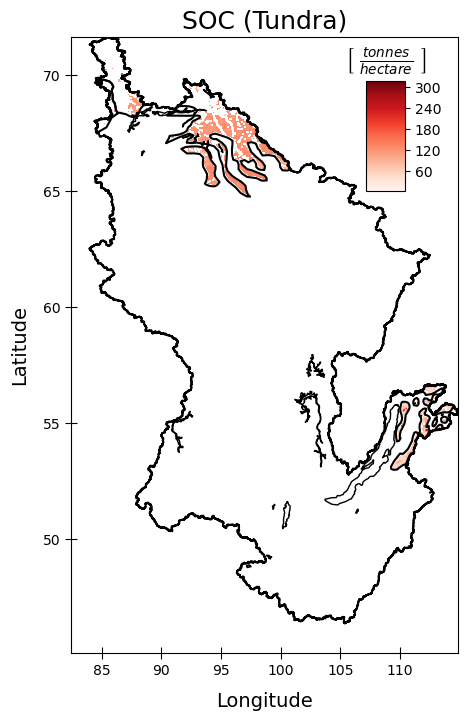

In [19]:
with rasterio.open(GSOC_Yenisey_Tundra_4326) as src:
    data = src.read(1, masked=True)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Compute the 2nd and 98th percentiles
   # p2 = np.percentile(valid_data_values, 2)
    p98 = np.percentile(data, 98.5)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Display the raster using the raster_extent and adjusted color limits
img = ax.imshow(data, cmap='Reds', extent=raster_extent)

# Set title and labels
ax.set_title('SOC (Tundra)', fontsize=18)
ax.set_xlabel('Longitude', color='black', fontsize=14, labelpad=10)
ax.set_ylabel('Latitude', color='black', fontsize=14, labelpad=10)
AGRO_Watershed.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)
tundra.plot(ax=ax, color='none', edgecolor='black', lw=1.5, zorder=6)
gpd_lakes.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=6)
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=10)

# Create custom colorbar
cb_ax = inset_axes(ax, width="10%", height="18%", loc='upper right', 
                   bbox_to_anchor=(-0.120, -0.060, 1, 1), bbox_transform=ax.transAxes)
cb = plt.colorbar(img, cax=cb_ax)
cb.set_label(r'$\left[\ \frac{tonnes}{hectare}\ \right]$', fontsize=10, labelpad=15)
#cb.set_label(r'$\left[\frac{tonnes}{hectare}\right]$', fontsize=20, labelpad=15)
cb.ax.tick_params(labelsize=10)
# Adjust label position and orientation
cb.ax.yaxis.set_label_coords(0.51, 1.18)
cb.ax.set_ylabel(cb.ax.get_ylabel(), rotation=0, fontsize=14, ha='center', va='center')
# Set the locator for the ticks
cb.locator = MaxNLocator(nbins=6)  # 'nbins' determines the maximum number of ticks
cb.update_ticks()

<br>

# Part III:

### Quantify SOC in each Biome

<br>

<br><br>

#### Reproject the Dictionary for Area Calculations

- EPSG:3573
- WGS 84 / North Pole LAEA Canada
- https://epsg.io/3573

<br><br>

In [20]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_raster(input_raster, output_raster, new_crs):
    """Reproject a raster to a new coordinate reference system."""

    # Check if the output file already exists
    if os.path.exists(output_raster):
        print(f"Output raster {output_raster} already exists!")
        return

    with rasterio.open(input_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, new_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': new_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=new_crs,
                    resampling=Resampling.bilinear
                )
    print(f"Raster reprojected to {new_crs} and saved as {output_raster}.")

In [21]:
# Change the CRS to an Equal Area ()
AGRO_Watershed_3573 = AGRO_Watershed.to_crs(3573)
eco_3573 = eco.to_crs(3573)
boreal_forest_3573 = boreal_forest.to_crs(3573)
tundra_3573 = tundra.to_crs(3573)

# Calculate the total area in square kilometers
AGRO_Watershed_3573_total_area_shapefile_km2 = AGRO_Watershed_3573.geometry.area.sum() / 1e6
eco_3573_total_area_shapefile_km2 = eco_3573.geometry.area.sum() / 1e6
boreal_forest_3573_total_area_shapefile_km2 = boreal_forest_3573.geometry.area.sum() / 1e6
tundra_3573_total_area_shapefile_km2 = tundra_3573.geometry.area.sum() / 1e6

print(f"Total = {AGRO_Watershed_3573_total_area_shapefile_km2:.0f} km2")
print(f"Total = {eco_3573_total_area_shapefile_km2:.0f} km2")
print(f"Taiga = {boreal_forest_3573_total_area_shapefile_km2:.0f} km2")
print(f"Tundra = {tundra_3573_total_area_shapefile_km2:.0f} km2")

Total = 2577444 km2
Total = 2546386 km2
Taiga = 1640927 km2
Tundra = 146571 km2


In [22]:
# Define new CRS
new_crs = 'EPSG:3573'

In [23]:
# Reproject SOC
GSOC_Yenisey_4326 = "GSOC_Yenisey.tif"
GSOC_Yenisey_3573 = "GSOC_Yenisey_3573.tif"
reproject_raster(GSOC_Yenisey_4326, GSOC_Yenisey_3573, new_crs)

Output raster GSOC_Yenisey_3573.tif already exists!


In [24]:
# Reproject SOC (Taiga)
GSOC_Yenisey_Taiga_4326 = "GSOC_Yenisey_Taiga_4326.tif"
GSOC_Yenisey_Taiga_3573 = "GSOC_Yenisey_Taiga_3573.tif" 
reproject_raster(GSOC_Yenisey_Taiga_4326, GSOC_Yenisey_Taiga_3573, new_crs)

Output raster GSOC_Yenisey_Taiga_3573.tif already exists!


In [25]:
# Reproject SOC (Tundra)
GSOC_Yenisey_Tundra_4326 = "GSOC_Yenisey_Tundra_4326.tif"
GSOC_Yenisey_Tundra_3573 = "GSOC_Yenisey_Tundra_3573.tif" 
reproject_raster(GSOC_Yenisey_Tundra_4326, GSOC_Yenisey_Tundra_3573, new_crs)

Output raster GSOC_Yenisey_Tundra_3573.tif already exists!


In [26]:
# Review metadata and make sure crs is changed
with rasterio.open(GSOC_Yenisey_3573) as src:
    meta = src.meta

meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4e+38,
 'width': 3883,
 'height': 4620,
 'count': 1,
 'crs': CRS.from_epsg(3573),
 'transform': Affine(662.8017829705676, 0.0, -2715817.916275249,
        0.0, -662.8017829705676, 4737231.902757984)}

#### Get total area covered by the raster data

In [27]:
with rasterio.open(GSOC_Yenisey_3573) as src:
    data = src.read(1, masked=True)
    pixel_area_m2 = abs(src.transform[0] * src.transform[4])
    valid_pixel_count = (data != src.nodata).sum()  # Count only valid pixels
    total_area_m2 = pixel_area_m2 * valid_pixel_count
    total_area_km2 = total_area_m2 / 1e6

print(f"Total area in square kilometers: {total_area_km2:.2f} km²")

Total area in square kilometers: 2504250.52 km²


In [28]:
# SOC Raster covers 97% of watershed
total_area_km2/AGRO_Watershed_3573_total_area_shapefile_km2

0.9716022905782987

<br>

### Function for quantifying SOC per shapefile

<br>

# NOTE

#### Unit Conversion in Total SOC Calculation:

The line total_soc_tonnes = (data * pixel_area_m2 * 10e-5).sum() assumes the raster values are in tonnes per hectare. The multiplication by pixel_area_m2 converts each pixel's SOC from tonnes per hectare to tonnes, and 10e-5 is the conversion factor from square meters to hectares. 

However, the correct factor should be 1e-4 (since 1 hectare = 10,000 m²). So, this line should be total_soc_tonnes = (data * pixel_area_m2 * 1e-4).sum().

In [29]:
def calculate_total_soc(raster_path, title):
    """
    Calculate the total Soil Organic Carbon (SOC) from a raster.
    
    - EPSG:3573 projection (polar-centric projection suitable for high-latitude regions). 
    - Assumes raster values are in tonnes per hectare and uses the EPSG:3573 projection. 
    - Pixel Area calculated by multiplying the height and width of a pixel (affine transform matrix)
    - Each pixel value (tonnes/ha) is multiplied by its area (m^2) to get the tonnage of SOC
    - The function accounts for nodata values by using a masked array approach.
    
    Parameters:
    raster_path (str): Path to the raster file.

    Returns:
    dict: A dictionary containing key SOC metrics including total SOC stock (in tonnes, kilograms, 
          and petagrams), mean density of SOC (kg/m²), and the total area of the raster in 
          square kilometers. The metrics provide insights into the spatial distribution and 
          magnitude of SOC stocks within the specified raster dataset.
    """
    with rasterio.open(raster_path) as src:
        data = src.read(1, masked=True)
        pixel_area_m2 = abs(src.transform[0] * src.transform[4])
        valid_pixel_count = (data != src.nodata).sum()
        total_area_m2 = pixel_area_m2 * valid_pixel_count
        total_area_km2 = total_area_m2 * 1e-6
        total_soc_tonnes = (data * pixel_area_m2 * 10e-4).sum()
        total_soc_kg = total_soc_tonnes * 1e3
        total_soc_tg = total_soc_tonnes * 1e-6
        total_soc_pg = total_soc_tonnes * 1e-9
        density = total_soc_kg / total_area_m2

        # Print the results
        print(title)
        print(f"Area = {total_area_km2:.0f} km²")
        print(f"Mean Density = {density:.3f} kg/m²")
        print(f"Total SOC = {total_soc_tonnes:.2f} tonnes")
        print(f"Total SOC = {total_soc_kg:.2f} kg")
        #print(f"Total SOC = {total_soc_tg:.2f} Tg")
        print(f"Total SOC = {total_soc_pg:.6f} Pg")

        # Return key metrics
        return {
            "total_area_km2": total_area_km2,
            "total_soc_tonnes": total_soc_tonnes,
            "total_soc_kg": total_soc_kg,
            "total_soc_pg": total_soc_pg, 
            "density_kg_per_m2": density,       
        }

In [30]:
# Total Watershed
total_soc = calculate_total_soc(GSOC_Yenisey_3573, 'Total')
xxx = (total_soc['total_area_km2']/AGRO_Watershed_3573_total_area_shapefile_km2)*100
print()
print('Raster Area Coverage:')
print(f"Total SOC = {xxx:.3f} %")
print()

# Taiga
taiga_soc = calculate_total_soc(GSOC_Yenisey_Taiga_3573, 'Taiga')

xxx = (taiga_soc['total_soc_tonnes']/total_soc['total_soc_tonnes'])*100
print()
print('Percent of Total SOC:')
print(f"{xxx:.3f} %")

xxx = (taiga_soc['total_area_km2']/boreal_forest_3573_total_area_shapefile_km2)*100
print()
print('Raster Coverage:')
print(f"{xxx:.3f} %")
print()

# Tundra
tundra_soc = calculate_total_soc(GSOC_Yenisey_Tundra_3573, 'Tundra')

xxx = (tundra_soc['total_soc_tonnes']/total_soc['total_soc_tonnes'])*100
print()
print('Percent of Total SOC:')
print(f"{xxx:.3f} %")


xxx = (tundra_soc['total_area_km2']/tundra_3573_total_area_shapefile_km2)*100
print()
print('Raster Coverage:')
print(f"{xxx:.3f} %")
print()

Total
Area = 2504251 km²
Mean Density = 81.458 kg/m²
Total SOC = 203990482944.00 tonnes
Total SOC = 203990482944000.00 kg
Total SOC = 203.990483 Pg

Raster Area Coverage:
Total SOC = 97.160 %

Taiga
Area = 1614843 km²
Mean Density = 83.656 kg/m²
Total SOC = 135091568640.00 tonnes
Total SOC = 135091568640000.00 kg
Total SOC = 135.091569 Pg

Percent of Total SOC:
66.224 %

Raster Coverage:
98.410 %

Tundra
Area = 137391 km²
Mean Density = 105.548 kg/m²
Total SOC = 14501415936.00 tonnes
Total SOC = 14501415936000.00 kg
Total SOC = 14.501416 Pg

Percent of Total SOC:
7.109 %

Raster Coverage:
93.737 %



### Concluding Remarks
The notebook shows how to utilize rasterio and GeoPandas to quantify the sum of raster band data for a given shapefile. The results show that this watershed contains about 204 Pg (1 Pg = 10e12 kg) of Soil Organic Carbon (SOC). For individual biomes, results show that 66% of the Total SOC resides in Boreal Forest (135 Pg), while 7% of the Total SOC resides in Tundra (14.5 Pg). These percent distributions closely resemble their respective area coverages.